<a href="https://colab.research.google.com/github/liudiepie/Introduction_to_Machine_Learning/blob/main/W6_Reinforcement_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Reinforcement Learning (RL) in PyTorch

### Reinforcement Learning
Enter Reinforcement Learning. In Reinforcement Learning, our model (commonly referred to as an agent in this context) interacts with an environment by taking actions  𝑎  and receives some sort of feedback from the environment in the form of a reward  𝑟 . In this sense, reinforcement learning algorithms learn by experience. We call the trajectory of going from start to finish of a task an episode, and often our agent will learn by undergoing many episodes.

Many reinforcement learning algorithms are modeled as Markov Decision Processes (MDPs). In these settings, we have a concept of a state  𝑠 , which encapsulates the situation of the agent (e.g. location, velocity). From each state  𝑠𝑡 , the agent takes an action  𝑎𝑡 , which results in a transition from one state  𝑠𝑡  to another  𝑠𝑡+1 . In many settings, there is stochasticity in this transition, meaning that there's is a distribution over  𝑠𝑡+1  conditioned on  𝑠𝑡  and  𝑎𝑡 . Often, several of these states are considered episode ending, after which the agent can no longer make any transitions or collect any more reward. These correspond to states such as reaching the final goal, a game concluding, or falling of a cliff. In the end, our goal is to learn a policy  𝜋 , or a mapping from states to actions.

In an MDP, we assume that we can always tell which state  𝑠𝑡  our agents is in. However, this isn't always the case. Sometimes, all we have access to are observations  𝑜𝑡  that provide information the state  𝑠𝑡 , but enough to precisely pinpoint the exact one. We call such settings Partially Observable Markov Decision Processes (POMDPs). Imagine for example a Roomba being trained to navigate a living room with RL. From its infrared and mechanical "bump" sensors, it receives partial information ( 𝑜𝑡 ) as to where it might be, but not a definitive location ( 𝑠𝑡 ). Operating as a POMDP adds a whole layer of complexity to RL algorithms. For the rest of day though, we'll focus on MDPs, as their much simpler and easier to use to teach basic concepts.

### Open AI Gym

In [ ]:
!pip install gym

In [1]:
import gym

### ForzenLake (a Grid World)

Let's start with a simple environment: FrozenLake.
Here's the official description from OpenAI gym:

> *Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.*

A visualization of FrozenLake as a grid world:

<img src="Figures/FrozenLake.PNG" alt="FrozenLake" style="width: 400px;"/>

At the start of an episode, we begin in the upper left corner (S).
Our goal is to move ourself to the lower right corner (G), avoiding falling into the holes (H).
Icy water is cold.

In reinforcement learning terms, each of the 16 locations on the grid are a state, and an action is attempting to move in one of four directions (left, down, right, up).
Each move will result in the agent's state changing from $s_t$ to $s_{t+1}$ as it changes location, unless it attempts to move in the direction of a wall, which results in the agent's state not changing (the agent doesn't move).
We receive a positive reward of "+1" for reaching the goal (G), discounted according to how long it took.
While there is not a negative reward for falling into a hole (H), the agent still pays a penalty in the sense that falling into the hole is episode-ending and therefore prevents it from receiving any reward. 
We want to learn a policy $\pi$ that takes us from our starting location (S) to the goal (G) in as few steps as possible.

To really establish what we are trying to accomplish here, it's worth debunking a few common initial misconceptions:

- **Knowledge of the states and transition probabilties:** From the top-down view, your first thought might be to plot out a path from the start to the finish, just as you would with a maze.
However, this view is provided to us the algorithm designers so we can visualize the problem at hand.
The agent learning the task does *not* get this prior knowledge; all we are about to tell it is that there are going to be 16 states and 4 possible actions from each state.
A more proper analogy would be if I blindfolded you and dropped you in the middle of a frozen lake, and told you your state (location) every time you decided to take a step in one of four directions, then set off fireworks when you stepped on the frisbee.

- **Knowledge of the goal (reward):** In OpenAI's official description of the environment, you (the agent) know what you're hoping to accomplish: You want to retrieve the frisbee, while avoiding falling through the ice.
The agent does *not* know this.
Rather, it learns the goal by experiencing rewards (or penalties), and the algorithm updates its policy such that it will be more (or less) likely to do those actions again.
Note that this means that if an agent never experiences certain rewards, it won't know they exist.

- **Prior knowledge of pathfinding, physics, etc.:** As a human, even if you haven't solved this task before, you still bring a tremondous amount of prior knowledge to this problem.
For example, you know the shortest path to a destination is a line.
You know that North, South, East, and West, are directions, and that going North and then South brings you back to where you already were.
You know ice is slippery.
You know icy water is cold.
You know being in icy cold water is bad.
It's important to keep in mind that our agent will begin knowing none of these things; it's initial policy is essentially picking actions completely at random.
By the end of the training, it still won't know what abstract concepts like "North/South," "cold," or "slippery" mean, but it will have (hopefully) learned a good policy that allows it to complete the goal.

#### Interacting with FrozenLake
This example is simple enough that we could code the environment and its interface ourselves fairly easily, but OpenAI has already done it, and we'd like to focus on the algorithm of solving it as much as possible.
We can create an instantiation of FrozenLake in a single line of code:

In [2]:
env = gym.make('FrozenLake-v0')
env.observation_space
env.action_space
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [3]:
# Non-slippery version

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)
env = gym.make('FrozenLakeNotSlippery-v0')
env.reset()

0

In [4]:
env.step(0)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [5]:
env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


Hm. 
Not great. 
Alright, so clearly picking random steps isn't very likely to take us to the goal.
It's apparent just from looking at the map that there're much better policies that we can learn.
How are we going to do so?

#### Q-learning
There are many algorithms that we can use, but let's choose Q-learning, which we covered earlier today.
Remember, in Q-learning (and SARSA, it turns out), we're trying learn the Q values for the states in our system.

The Q value for a policy $\pi$ is a function of the state $s$ and action $a$ and is defined as the following:
\begin{equation}
Q_\pi (s,a) = \mathbb{E}\big[\sum_{t=0}^{\infty} \gamma^t r_t \big|\pi, s_0 = s, a_0 = a\big]
\end{equation}
Intuitively, the Q value is the total reward (including discounting) that the agent will gain if it takes action $a$ from state $s$ and then follows policy $\pi$ for the rest of the episode.
As one might expect, if Q is known exactly, the agent will attain the highest reward from $s$ if the policy $\pi$ is to pick the $a$ with the highest Q value.

Okay, so if we know the Q values for the system, then we can trivially find the optimal policy.
So what are the Q values of the system?
Well, at the beginning, we don't know, but we can try to learn them through experience.
This is where Q-learning comes in.
Q-learning iteratively updates the Q values in the following way:
\begin{equation}
Q_\pi (s_t, a_t) \leftarrow (1 - \alpha) \cdot Q_\pi(s_t, a_t) + \alpha \cdot \big(r_t + \gamma \max_a Q_\pi(s_{t+1}, a)\big)
\end{equation}
Notice that Q-learning is an *off-policy* method, in the sense that you don't actually learn from the trajectory you actually took (otherwise it'd be SARSA).
Instead, we learn from the *greedy* transition, i.e. the best action we know how to take.

And that's it! 
We run our agent through many episodes, experiencing many $s_t \rightarrow a_t \rightarrow s_{t+1}$ transitions and rewards, and just like that, we eventually learn a good Q function (and thus a good policy).
Now of course, there are a bunch of small details and tweaks to make this work in practice, but we'll get to those later.

#### Q-learning in FrozenLake
FrozenLake is a very simple setting, one that we would call a toy problem.
With only 16 states and 4 actions, there are only 64 state-action pairs possible (16x4=64), less if we account for the goal and the holes being episode ending (for simplicity though, we won't). 
With this few state-action pairs, we can actually solve this problem tabularly.
Let's set up a Q table, and initialize the Q-values for all state-action pairs to zeros.
Note that while we could, we're actually not going to need PyTorch in this example; PyTorch's autograd and neural network libraries are unnecessary here, as we're only going to be modifying a table of numbers.
Instead, we'll use a Numpy array to store the Q table.

In [6]:
import numpy as np

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])

A few hyperparameters we're going to set:
- `alpha`: learning rate for the Q function
- `gamma`: discount rate for future rewards
- `num_episodes`: number of episodes (trajectories from start to goal/hole) our agent will learn from

We're also going to store our rewards in an array called `rs`.

In [7]:
# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

In [8]:
for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False
    
    #Reset environment and get first new observation
    s = env.reset()
    
    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))
        
        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)
        
        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))
        
        # Add reward to episode total
        r_sum_i += r*gamma**t
        
        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

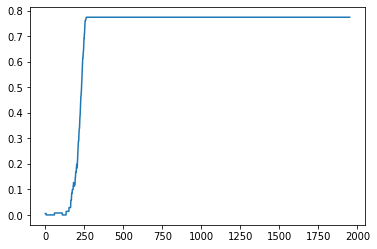

In [9]:
## Plot reward vs episodes
import matplotlib.pyplot as plt

# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0)) 
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

In [10]:
# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)
    
print("Rewards: {0}".format(num_Gs))

Rewards: [  3. 161. 200. 200. 200. 200. 200. 200. 200. 200.]


### PyTorch in RL

### Cart Pole

In [20]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2445 sha256=e35763987af5f811ef6bf500ac6ff2a50848dbaf624574b81389775ed75a0580
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender
  Attempting uninstall: colabgymrender
    Found existing installation: colabgymrender 1.0.9
    Uninstalling colabgymrender-1.0.9:
      Successfully uninstalled colabgymrender-1.0.9


In [1]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v0")
env = Recorder(env, '/.video')

observation = env.reset()
terminal = False
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)

env.play()

 97%|█████████▋| 33/34 [00:00<00:00, 241.72it/s]


In [2]:
env.close()

In [3]:
# Based on: https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/

from collections import deque
import random
import math

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, 2)

    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x        
    

class DQNCartPoleSolver:
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.dqn = DQN()
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.dqn.parameters(), lr=0.01)

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return torch.tensor(np.reshape(state, [1, 4]), dtype=torch.float32) 
    
    def choose_action(self, state, epsilon):
        if (np.random.random() <= epsilon):
            return self.env.action_space.sample() 
        else:
            with torch.no_grad():
                return torch.argmax(self.dqn(state)).numpy()

    def remember(self, state, action, reward, next_state, done):
        reward = torch.tensor(reward)
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        y_batch, y_target_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y = self.dqn(state)
            y_target = y.clone().detach()
            with torch.no_grad():
                y_target[0][action] = reward if done else reward + self.gamma * torch.max(self.dqn(next_state)[0])
            y_batch.append(y[0])
            y_target_batch.append(y_target[0])
        
        y_batch = torch.cat(y_batch)
        y_target_batch = torch.cat(y_target_batch)
        
        self.opt.zero_grad()
        loss = self.criterion(y_batch, y_target_batch)
        loss.backward()
        self.opt.step()        
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                if e % 100 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

if __name__ == '__main__':
    agent = DQNCartPoleSolver()
    agent.run()
    agent.env.close()

[Episode 0] - Mean survival time over last 100 episodes was 20.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 13.36 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 41.25 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 58.72 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 140.74 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 158.73 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 186.52 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 150.15 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 36.96 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 9.44 ticks.
Did not solve after 999 episodes 😞


Reinforcement learning can be kind of noisy. In some sense, it depends on your agent "lucking" into the right behavior so that it can learn from it, and occasionally one can get stuck in a bad rut. Even if your agent fails to "solve" the problem (i.e. reach 200 ticks), you should still see the mean survival time mostly climbing as the agent experiences more episodes. You may need to re-run learning a couple times for the agent to reach 200 ticks.